<a href="https://colab.research.google.com/github/JoeL-8883/Fencing-Score-Predictor/blob/main/predict_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from bs4 import BeautifulSoup
import requests
import os
import gdown
import kagglehub
import random

In [2]:
path = kagglehub.dataset_download("foillee/fencing-points")
csv_path = os.path.join(path, 'data.csv')
df = pd.read_csv(csv_path)
df = df.sort_values(by='date')
df['date'] = pd.to_datetime(df['date'])
df.head()

,fie_ID,fencer_name,age,dob,nationality,rank,host_city,event_type,points_earned,date
5279,17148,ROWLES Thomas,17,1990-05-30,GBR,504,Londres,Satellite,0.0,2007-10-21
4878,14529,REMIJN Martin,18,1989-07-25,NED,251,Londres,Satellite,0.0,2007-10-21
4873,16321,STIJLAART Mats,17,1990-10-08,NED,250,Londres,Satellite,0.0,2007-10-21
4864,17823,AVOLA Giorgio,18,1989-05-08,ITA,247,Londres,Satellite,2.0,2007-10-21
4858,3247,KENBER Jamie,20,1986-11-14,GBR,245,Londres,Satellite,3.0,2007-10-21


In [3]:
# Satellite events give very few points which could negatively affect trajectories
df = df[df['event_type'] != 'Satellite']

'''Delete data for fencers who do not compete regularly'''
# NOTE - the threshold must be g.e.q sequence_length / train_split
threshold = 20 # the number of non-satellite events each fencer must have attended to be considered
fencer_counts = df['fencer_name'].value_counts()
fencers_to_delete = fencer_counts[fencer_counts < 20].index
print(f'Deleting {len(fencers_to_delete)} fencers')
df = df[~df['fencer_name'].isin(fencers_to_delete)]

Deleting 1735 fencers


In [4]:
'''Compute rolling averages of points earned'''
window_size = 8
df['rolling_avg_points'] = df.groupby('fencer_name')['points_earned'].transform(lambda x: x.rolling(window=window_size).mean())

# Fill NaN values
df['rolling_avg_points'] = df['rolling_avg_points'].fillna(method='bfill') # Fill initial NaNs with the first valid value
df['rolling_avg_points'] = df['rolling_avg_points'].fillna(0) # Fill any remaining NaNs with 0 if necessary

# Normalise
rolling_mean = df['rolling_avg_points'].mean()
rolling_std = df['rolling_avg_points'].std()
df['rolling_avg_normalised'] = (df['rolling_avg_points'] - rolling_mean) / rolling_std

/tmp/ipython-input-4-1290776390.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rolling_avg_points'] = df['rolling_avg_points'].fillna(method='bfill') # Fill initial NaNs with the first valid value


In [5]:
# Normalise and rescale other quantities
points_mean = df['points_earned'].mean()
points_std = df['points_earned'].std()
df['points_normalised'] = (df['points_earned'] - points_mean) / points_std

df['age_normalised'] = (df['age'] - df['age'].mean()) / df['age'].std()

max_rank = df['rank'].max()
min_rank = df['rank'].min()
df['rank_rescaled'] = (df['rank'] - min_rank) / (max_rank - min_rank)

In [6]:
# One-hot encoding of nationalities
one_hot_nationality = pd.get_dummies(df['nationality'], prefix='nationality')
df = pd.concat([df, one_hot_nationality], axis=1)

In [7]:
class FencerSequencesDataset(Dataset):
  def __init__(self, df, window_size=10, horizon=1):
    self.window_size = window_size
    self.horizon = horizon
    self.sequences = []
    self.targets = []

    for fencer_name, fencer_df in df:
      # Concatenate features
      features = fencer_df[['points_normalised',
                            'rolling_avg_normalised',
                            'rank_rescaled',
                            'age_normalised']].values
      nationality_columns = [col for col in fencer_df.columns if col.startswith('nationality_')]
      all_features = np.concatenate((features, fencer_df[nationality_columns].values), axis=1)

      # Create sliding windows of different lengths to be used for training
      n_comps_entered = len(all_features)
      for start in range(n_comps_entered - window_size - horizon + 1):
        end = start + window_size
        seq = all_features[start:end]
        target = all_features[end:end + horizon, 0] # index 0 corresponds to points_normalised

        self.sequences.append(torch.tensor(seq, dtype=torch.float32))
        self.targets.append(torch.tensor(target, dtype=torch.float32))

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    return self.sequences[idx], self.targets[idx]

### Split the data
Split fencers so a given fencer is used entirely for training or validation or testing. This way the model may generalise to new fencing data by learning patterns in fencing performance trajectory.

In [8]:
train_split = 0.8
val_split   = 0.1
test_split  = 0.1

unique_fencers = df['fencer_name'].unique()
random.shuffle(unique_fencers)
num_fencers = len(unique_fencers)

train_size = int(num_fencers * train_split)
val_size = int(num_fencers * val_split)
test_size = num_fencers - train_size - val_size

# Get lists of fencers
train_fencers = unique_fencers[:train_size]
remaining_fencers = unique_fencers[train_size:]
val_fencers, test_fencers = np.array_split(remaining_fencers, 2)

# Get data frame for train, validation and test fencers
train_df = df[df['fencer_name'].isin(train_fencers)]
val_df   = df[df['fencer_name'].isin(val_fencers)]
test_df  = df[df['fencer_name'].isin(test_fencers)]

# There will be disparity in the number of fencers, since
print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 14188
Validation size: 1834
Test size: 1944


Load the data

In [9]:
train_grouped = train_df.groupby('fencer_name')
val_grouped   = val_df.groupby('fencer_name')
test_grouped  = test_df.groupby('fencer_name')

training_data = FencerSequencesDataset(train_grouped, window_size=10, horizon=1)
validation_data = FencerSequencesDataset(val_grouped, window_size=10, horizon=1)
testing_data = FencerSequencesDataset(test_grouped, window_size=10, horizon=1)

In [10]:
batch_size = 32
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=False)

Create model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
# Model is trained to predict the points earned in the next competition
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.25):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden=None):
    lstm_out, hidden = self.lstm(x, hidden)
    out = self.dropout(lstm_out[:, -1, :])
    out = self.fc(out) # project hidden state to output representation

    return out, hidden

In [13]:
input_size = 4 # number of features
nationality_count = len([col for col in df.columns if col.startswith('nationality_')])
input_size += nationality_count

hidden_size = 256
output_size = 1 # i.e. predicting points earned from a competition
num_layers = 4

dropout = 0.3
best_val_loss = float('inf')
patience = 5
counter = 0
best_model = None

model = LSTM(input_size, hidden_size, output_size, num_layers, dropout)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.005) # Reduced learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

Train the model

In [14]:
def eval_model(model, dataloader):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for sequences, targets in dataloader:
      sequences = sequences.to(device)
      targets = targets.to(device)

      outputs, _ = model(sequences)
      loss = criterion(outputs, targets)
      total_loss += loss.item()
    average_loss = total_loss / len(dataloader)
    return average_loss

In [15]:
train = True
epochs = 50
patience = 5
best_val_loss = float('inf')
counter = 0

if train:
  for epoch in range(epochs):
      model.train()
      total_train_loss = 0

      for sequences, targets in train_dataloader:
        batch_loss = 0
        sequences = sequences.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs, _ = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Add gradient clipping
        optimizer.step()
        total_train_loss += loss.item()
      scheduler.step()

      average_train_loss = total_train_loss / len(train_dataloader)
      print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {average_train_loss:.4f}')

      # Validation losses
      val_loss = eval_model(model, val_dataloader)
      print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}')

      if val_loss < best_val_loss:
        counter = 0
        best_val_loss = val_loss
        best_model = model.state_dict()
      else:
        counter +=1
        if counter >= patience:
          print(f'Early stopping at epoch {epoch+1}')
          break
torch.save(best_model, 'model.pth')

Epoch [1/50], Train Loss: 0.9112
Epoch [1/50], Validation Loss: 0.8056
Epoch [2/50], Train Loss: 0.8007
Epoch [2/50], Validation Loss: 0.7591
Epoch [3/50], Train Loss: 0.8000
Epoch [3/50], Validation Loss: 0.7712
Epoch [4/50], Train Loss: 0.7998
Epoch [4/50], Validation Loss: 0.7529
Epoch [5/50], Train Loss: 0.7989
Epoch [5/50], Validation Loss: 0.7614
Epoch [6/50], Train Loss: 0.7931
Epoch [6/50], Validation Loss: 0.7520
Epoch [7/50], Train Loss: 0.7930
Epoch [7/50], Validation Loss: 0.7606
Epoch [8/50], Train Loss: 0.7933
Epoch [8/50], Validation Loss: 0.7545
Epoch [9/50], Train Loss: 0.7914
Epoch [9/50], Validation Loss: 0.7587
Epoch [10/50], Train Loss: 0.7923
Epoch [10/50], Validation Loss: 0.7650
Epoch [11/50], Train Loss: 0.7916
Epoch [11/50], Validation Loss: 0.7599
Early stopping at epoch 11


In [16]:
test_loss = eval_model(model, test_dataloader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.9872


In [17]:
if train == False:
  model_path = '/content/model.pth'
  model = LSTM(input_size, hidden_size, output_size, num_layers, dropout)

  if str(device) == 'cpu':
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
  else:
    model = model.to(device)
    model.load_state_dict(torch.load(model_path))

Make predictions

In [18]:
# Get the next competition date based on the date of the next event from the season before
# Fencing competitions are held within days of each other in previous seasons so this assumption is valid
def get_next_comp_date(pred_df, nationality,date_df=None):
  '''
    Predict the next date of the fencing competiton based on when competitions were held the previous season

    Args:
      pred_df: the dataframe of predictions
      nationality: the nationality of the fencer to predict for
      date_df: a dataframe of the dates of all competitions past and predicted

    Returns:
      pred_date: predicted date of the next competition
      date_df: the dataframe of all dates of competitions
  '''

  # Obtain an initial dataframe of competitions of unique dates based on region
  if date_df is None:
    nationality_df = df[df['nationality'] == nationality]
    date_df = nationality_df.drop_duplicates(subset=['date'])

  # Compute competition dates from the previous year, starting on the date of the last competition
  last_comp_date = pred_df.iloc[-1]['date']
  prev_year = last_comp_date - pd.Timedelta(days=365)
  prev_comp_dates = date_df[(date_df['date'] >= prev_year) & (date_df['date'] < last_comp_date)]
  prev_comp_dates = prev_comp_dates.sort_values(by='date')

  if prev_comp_dates.empty:
    # !!! This may raise an error if a fencer from a country without a strong fencing background is chosen
    raise Exception(f'No previous competitions found, exception has not yet been implemented.')
  else:
    # Search for the most recent competition then the compeition that comes after
    # Get the second entry as the first entry is just the last competiton the fencer competed at
    pred_date_df = prev_comp_dates.iloc[[1]].copy()
    pred_date_df['date'] = pred_date_df['date'] + pd.Timedelta(days=365)
    date_df = pd.concat([date_df, pred_date_df], ignore_index=True)
    pred_date = pred_date_df.iloc[0]['date']
    return pred_date, date_df

In [19]:
def forecast(model, fencer_df, num_predictions, tail_length=15):
  '''
  Make auto-regressive predictions of a fencers future performance based on previous results

  Args:
    model: the trained LSTM used to make predictions
    fencer_df: dataframe of the chosen fencer's results
    num_predictions: number of predictions to be made
    tail_length: how many of the most recent competitions should be used to make predictions

  Returns:
    pred_df: dataframe of the predictions consisting of points earned and the date of the next competition
  '''


  # !!! Why is only a fraction of previous competitions used?

  model.eval()
  fencer_copy_df = fencer_df.copy().sort_values(by='date')
  features_cols = ['points_normalised',
                   'rolling_avg_normalised',
                   'rank_rescaled',
                   'age_normalised']
  nationality_cols = [col for col in fencer_copy_df.columns if col.startswith('nationality_')]
  all_cols = features_cols + nationality_cols
  history = fencer_copy_df[all_cols].values.astype(np.float32)
  history_tensor = torch.tensor(history[-tail_length:], dtype=torch.float32, device=device).unsqueeze(0) # Add batch dimension


  # Initialise prediction df
  last_comp_row = fencer_copy_df.iloc[-1]
  last_comp_data = {
      'fencer_name': last_comp_row['fencer_name'],
      'age': last_comp_row['age'],
      'points_earned': last_comp_row['points_earned'],
      'date': last_comp_row['date']
  }
  date_df = None

  # Details about next predictions
  pred_df_headers = ['fencer_name', 'age', 'points_earned', 'date']
  pred_df = pd.DataFrame(data=last_comp_data, columns=pred_df_headers, index=[0])

  with torch.no_grad():
    hidden = None

    for _ in range(num_predictions):
      # Make prediction based on data
      output, hidden = model(history_tensor, hidden)
      predicted_points_normalised = output.item()

      # Compute new predicted_rolling_avg based on previous sequences
      last_points_window = history_tensor[0, :, 0].cpu().numpy()
      new_window = np.append(last_points_window, predicted_points_normalised)
      predicted_rolling_avg_normalised = np.mean(new_window[-window_size:]) # Note the history tensor uses normalised values

      # Features for next prediction
      last_comp_date = pred_df.iloc[-1]['date']
      nationality = fencer_df.iloc[-1]['nationality']
      next_comp_date_pred, date_df = get_next_comp_date(pred_df, nationality, date_df)
      dob = fencer_df.iloc[-1]['dob']
      next_age = int((next_comp_date_pred - pd.to_datetime(dob)).days / 365.25)

      # Create data for autoregressive predictions
      nationality_features = fencer_df.iloc[-1][nationality_cols].values.tolist()
      rank = fencer_df.iloc[-1]['rank'] # Using the last known rank - this could be improved
      next_age_normalised = (next_age - df['age'].mean()) / df['age'].std()
      next_rank_rescaled = fencer_df['rank_rescaled'].iloc[-1]

      new_features = [
          predicted_points_normalised,
          predicted_rolling_avg_normalised,
          next_age_normalised,
          next_rank_rescaled
      ]
      new_features.extend(nationality_features)
      new_features = np.array(new_features, dtype=np.float32)
      new_features_tensor = torch.tensor(new_features, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0) # Add batch and sequence length dimensions

      # Update history for the next prediction by sliding the window
      # : select all sequences in the batch
      # 1: select all datapoints but the first datapoint (sliding the window)
      # : select all features
      history_tensor = torch.cat((history_tensor[:, 1:, :], new_features_tensor), dim=1)

      # Denormalise prediction
      predicted_rolling_avg = (predicted_rolling_avg_normalised * rolling_std) + rolling_mean
      predicted_points = (predicted_points_normalised * points_std) + points_mean

      new_row = {col: None for col in pred_df_headers}
      new_row.update({
          'fencer_name': fencer_df.iloc[-1]['fencer_name'],
          'age': next_age,
          'points_earned': predicted_points,
          'date': pd.to_datetime(next_comp_date_pred)
      })
      pred_df = pd.concat([pred_df, pd.DataFrame([new_row])], ignore_index=True)

  return pred_df.sort_values(by='date')

In [23]:
### Make predictions
fencer_name = 'IIMURA Kazuki'
num_predictions = 50


fencer_df = df[df['fencer_name'] == fencer_name]
if fencer_df.empty:
  print(f'No data found for {fencer_name}')


predictions = forecast(model, fencer_df, num_predictions)[1:]
print(predictions)

      fencer_name  age  points_earned       date
1   IIMURA Kazuki   21      16.927325 2025-06-24
2   IIMURA Kazuki   21      17.795683 2025-07-29
3   IIMURA Kazuki   21      17.578084 2025-11-22
4   IIMURA Kazuki   21      17.597471 2025-12-06
5   IIMURA Kazuki   22      17.457561 2026-01-10
6   IIMURA Kazuki   22      17.547560 2026-02-07
7   IIMURA Kazuki   22      17.432471 2026-03-07
8   IIMURA Kazuki   22      17.281848 2026-03-22
9   IIMURA Kazuki   22      16.998248 2026-05-02
10  IIMURA Kazuki   22      17.359742 2026-05-17
11  IIMURA Kazuki   22      17.566969 2026-06-24
12  IIMURA Kazuki   22      17.671628 2026-07-29
13  IIMURA Kazuki   22      17.979841 2026-11-22
14  IIMURA Kazuki   22      18.220669 2026-12-06
15  IIMURA Kazuki   23      18.485569 2027-01-10
16  IIMURA Kazuki   23      18.630440 2027-02-07
17  IIMURA Kazuki   23      18.678032 2027-03-07
18  IIMURA Kazuki   23      18.702453 2027-03-22
19  IIMURA Kazuki   23      18.722798 2027-05-02
20  IIMURA Kazuki   

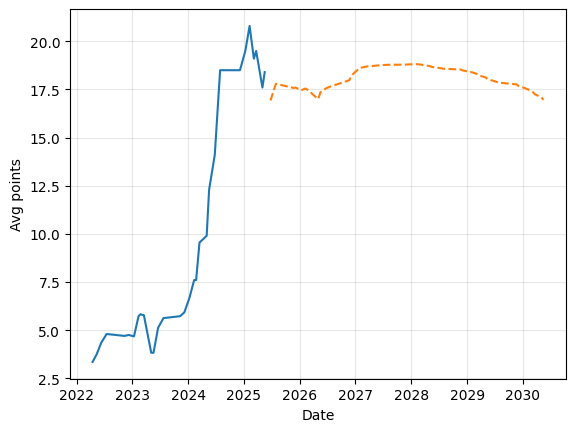

In [24]:
### Visualise predictions
plt.xlabel('Date')
plt.ylabel('Avg points')
plt.grid(True, alpha=0.3)


fencer_points = fencer_df['points_earned'].rolling(window=10).mean()

plt.plot(fencer_df['date'], fencer_points)
plt.plot(predictions['date'], predictions['points_earned'], linestyle='--')
plt.show()

## TO DO
- Encode event type as a feature